<a href="https://colab.research.google.com/github/Shisiajoy/BreastCancerPrediction/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORTS

In [1]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp


from PIL import Image
from IPython.display import display


from scipy import ndimage
from shutil import copyfile
from google.colab import userdata
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, Dropout, BatchNormalization,Input , Flatten
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
# Access the secret key
secret_value = userdata.get('shisiajoy')


In [3]:
pip install pillow


In [4]:
# Install Kaggle API if not already installed
!pip install kaggle


In [5]:
!kaggle datasets download -d gauravduttakiit/rsna-screening-mammography-breast-cancer-detection


Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/rsna-screening-mammography-breast-cancer-detection
License(s): CC0-1.0
 99% 993M/0.98G [00:17<00:00, 52.9MB/s]
100% 0.98G/0.98G [00:17<00:00, 59.9MB/s]


In [6]:
!unzip rsna-screening-mammography-breast-cancer-detection.zip -d /content/rsna_mammography_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna_mammography_dataset/output/train/63617_1917877119.png  
  inflating: /content/rsna_mammography_dataset/output/train/63617_887426674.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1186739164.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1657034655.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_335778602.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_625719002.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_1154699412.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_549972940.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_599167493.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_939566995.png  
  inflating: /content/rsna_mammography_dataset/output/train/63627_1214214469.png  
  inflating: /content/rsna_mammography_dat

In [7]:
#path to csv files
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")
testinfo = pd.read_csv("/content/rsna_mammography_dataset/test.csv")

In [8]:
traininfo.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [9]:
testinfo.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [10]:
#path image folder
image_folder_path = '/content/rsna_mammography_dataset/output/train'    #train

Trying to load: /content/rsna_mammography_dataset/output/train/10006_1459541791.png


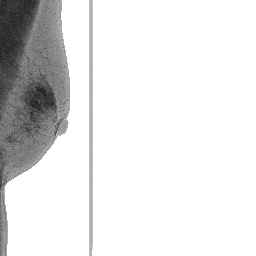

In [11]:
def load_image(patient_id, image_id, image_folder_path):
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    print(f"Trying to load: {image_path}")  # Debugging statement
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None

# Test with a single image
test_patient_id = '10006'  # Replace with a valid patient_id
test_image_id = '1459541791'  # Replace with a valid image_id
image = load_image(test_patient_id, test_image_id, image_folder_path)
if image:
    display(image)


Displaying a cancer image:


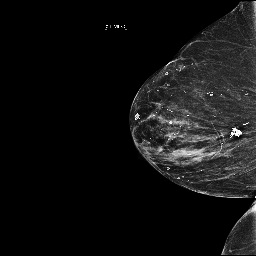

Displaying a no-cancer image:


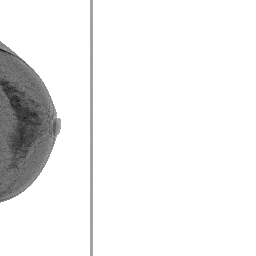

In [12]:
def load_image(patient_id, image_id, image_folder_path):
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None

# Group images by cancer label
def group_images_by_cancer(df, image_folder_path):
    grouped_images = {'cancer': [], 'no_cancer': []}

    # Assuming cancer column contains binary values (0 or 1)
    for _, row in df.iterrows():
        patient_id = row['patient_id']
        image_id = row['image_id']
        cancer_label = row['cancer']  # Use 'cancer' column for labeling

        image = load_image(patient_id, image_id, image_folder_path)
        if image:
            if cancer_label == 1:  # Assuming 1 indicates 'cancer'
                grouped_images['cancer'].append(image)
            elif cancer_label == 0:  # Assuming 0 indicates 'no cancer'
                grouped_images['no_cancer'].append(image)

    return grouped_images

# Test grouping images
grouped_images = group_images_by_cancer(traininfo, image_folder_path)

# Display a sample image from each group
if grouped_images['cancer']:
    print("Displaying a cancer image:")
    display(grouped_images['cancer'][0])
if grouped_images['no_cancer']:
    print("Displaying a no-cancer image:")
    display(grouped_images['no_cancer'][0])


### ORGANIZE TEST DATA INTO 'CANCER' AND 'NO_CANCER'

In [13]:
# Define paths
base_path = '/content/rsna_mammography_dataset/output/train'
cancer_path = os.path.join(base_path, 'cancer')
no_cancer_path = os.path.join(base_path, 'no_cancer')

# Create the cancer and no_cancer directories
os.makedirs(cancer_path, exist_ok=True)
os.makedirs(no_cancer_path, exist_ok=True)

# Function to move images to respective directories
def organize_images(row):
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer_label = row['cancer']  # Assuming 1 indicates cancer, 0 indicates no cancer

    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(base_path, image_filename)

    # Check if the image exists
    if os.path.exists(image_path):
        if cancer_label == 1:
            shutil.move(image_path, os.path.join(cancer_path, image_filename))
        else:
            shutil.move(image_path, os.path.join(no_cancer_path, image_filename))
    else:
        print(f"Image {image_filename} not found in {base_path}.")

# Apply the function to organize images
traininfo.apply(organize_images, axis=1)
print("Images have been organized into 'cancer' and 'no_cancer' folders.")


Images have been organized into 'cancer' and 'no_cancer' folders.


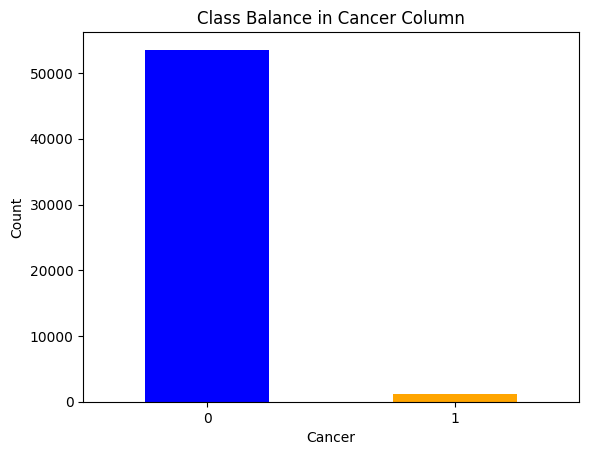

In [15]:
# Count the occurrences of each class in the 'cancer' column
class_counts = traininfo['cancer'].value_counts()

# Plot the class balance
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Balance in Cancer Column')
plt.xlabel('Cancer')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### DATA SPLIT AND DATA AUGMENTATION

In [17]:
# Data generators with validation split and data augmentation
datagenerator = ImageDataGenerator(
    rescale=1./255,             # Rescales the pixel values to be between 0 and 1
    validation_split=0.2,       # 20% of the data will be used for validation
    width_shift_range=0.2,      # Randomly shifts the images horizontally by 20% of the width
    rotation_range=20,          # Randomly rotates the images by up to 20 degrees
    height_shift_range=0.2,     # Randomly shifts the images vertically by 20% of the height
    shear_range=0.2,            # Applies a shear transformation with a magnitude of 0.2
    zoom_range=0.2,             # Randomly zooms into images by up to 20%
    horizontal_flip=True,       # Randomly flips half of the images horizontally
    fill_mode='nearest'         # Fills in newly created pixels after transformations
)


In [18]:
traingenerator = datagenerator.flow_from_directory(base_path , target_size = (150 ,150), batch_size = 32 , class_mode = 'binary' ,subset = 'training', color_mode='grayscale')

Found 43766 images belonging to 2 classes.


In [19]:
validationgenerator = datagenerator.flow_from_directory(base_path , target_size = (150 ,150), batch_size = 32 , class_mode = 'binary' ,subset = 'validation', color_mode='grayscale')

Found 10940 images belonging to 2 classes.


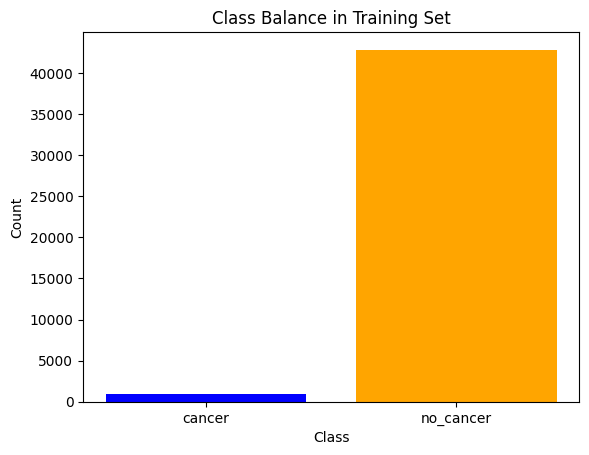

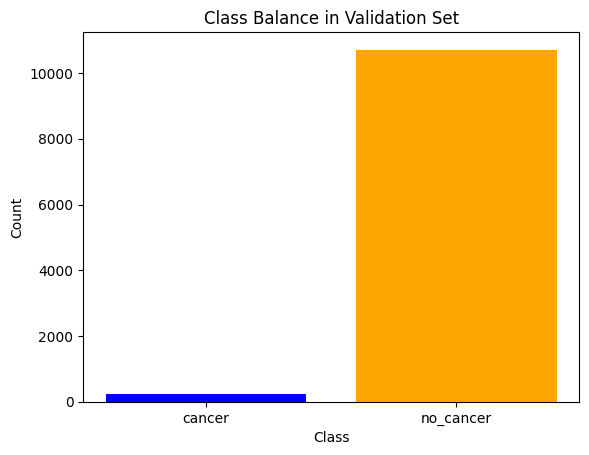

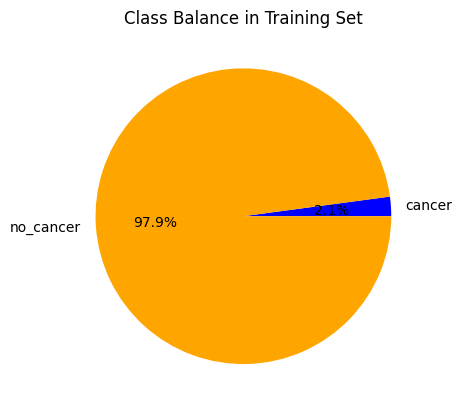

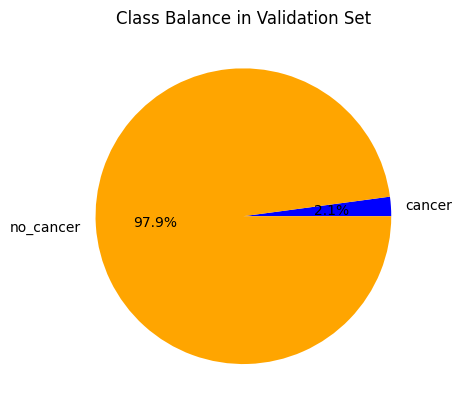

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming traingenerator and validationgenerator are defined as shown

# Get class indices
train_class_indices = traingenerator.class_indices
val_class_indices = validationgenerator.class_indices

# Get class counts for training and validation sets
train_class_counts = Counter(traingenerator.classes)
val_class_counts = Counter(validationgenerator.classes)

# Map class indices to class labels
train_labels = {v: k for k, v in train_class_indices.items()}
val_labels = {v: k for k, v in val_class_indices.items()}

# Plot the class balance for the training set
plt.bar([train_labels[k] for k in train_class_counts.keys()], train_class_counts.values(), color=['blue', 'orange'])
plt.title('Class Balance in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the class balance for the validation set
plt.bar([val_labels[k] for k in val_class_counts.keys()], val_class_counts.values(), color=['blue', 'orange'])
plt.title('Class Balance in Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot pie chart for training set
plt.pie(train_class_counts.values(), labels=[train_labels[k] for k in train_class_counts.keys()], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Class Balance in Training Set')
plt.show()

# Plot pie chart for validation set
plt.pie(val_class_counts.values(), labels=[val_labels[k] for k in val_class_counts.keys()], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Class Balance in Validation Set')
plt.show()


### MODELING

In [17]:
# Define the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (6, 6), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 145, 145, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 70, 70, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 33, 33, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,097 (16.36 MB)

 Trainable params: 4,288,097 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### TRAINING

In [18]:
history = model.fit(traingenerator, validation_data=validationgenerator,epochs = 5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2534s 2s/step - accuracy: 0.9789 - loss: 0.1241 - val_accuracy: 0.9789 - val_loss: 0.1039
Epoch 2/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2486s 2s/step - accuracy: 0.9790 - loss: 0.1092 - val_accuracy: 0.9789 - val_loss: 0.1068
Epoch 3/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2556s 2s/step - accuracy: 0.9783 - loss: 0.1107 - val_accuracy: 0.9789 - val_loss: 0.1023
Epoch 4/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2485s 2s/step - accuracy: 0.9790 - loss: 0.1056 - val_accuracy: 0.9789 - val_loss: 0.1024
Epoch 5/5
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2458s 2s/step - accuracy: 0.9788 - loss: 0.1074 - val_accuracy: 0.9789 - val_loss: 0.1024


In [19]:
# Saving the entire model to the native Keras format
model.save('my_model.keras')


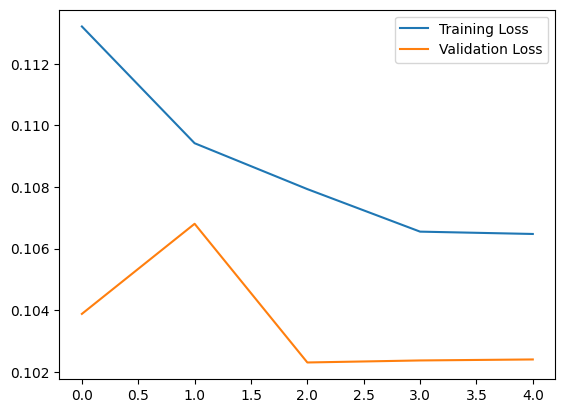

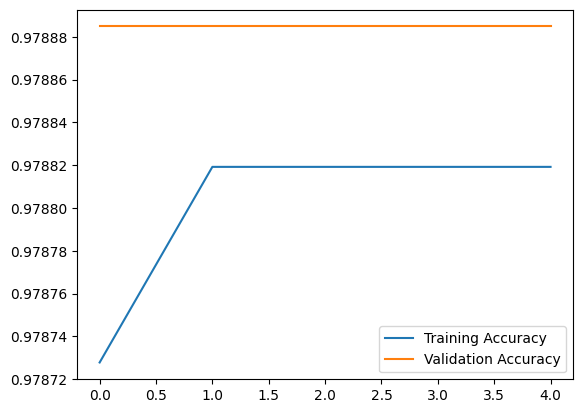

In [20]:
# Plot training history
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned from model.fit()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
